# Probability Calculation
Calculate the probability by summing over the kde above the point.

H0 bootstrapping: Lx-T 8.7, 2.8sigma; Ysz-T 14.0, 4.1sigma

H0 mcmc: Lx-T 8.7, 2.4sigma; Ysz-T 14.0, 2.6sigma

In [2]:
# Read the data
import pandas as pd
data = pd.read_csv('/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/h0_direct_compare.csv')
data['Delta_H0'] *= 100    # Also brings delta_h0 to the order of magnitude of significance


In [3]:
data_joint = pd.merge(left=data[data['Relations']=='$L_\\mathrm{{X}}-T$'], 
                      right=data[data['Relations']=='$Y_\\mathrm{{SZ}}-T$'],
                      on='Lightcone', how='inner')
data_joint

,Relations_x,Delta_H0_x,Significance_x,Glon_x,Glat_x,Lightcone,Relations_y,Delta_H0_y,Significance_y,Glon_y,Glat_y
0,$L_\mathrm{{X}}-T$,5.184379,2.356872,-40.641361,42.472119,0,$Y_\mathrm{{SZ}}-T$,3.469992,1.174986,-64.000000,-2.000000
1,$L_\mathrm{{X}}-T$,3.766828,1.552214,52.866108,58.861169,1,$Y_\mathrm{{SZ}}-T$,4.135417,1.850623,156.198155,-40.709781
2,$L_\mathrm{{X}}-T$,2.750494,1.120093,137.559549,44.219754,2,$Y_\mathrm{{SZ}}-T$,4.202612,1.529209,-92.000000,-14.000000
3,$L_\mathrm{{X}}-T$,5.232350,2.252205,103.455472,-22.855878,3,$Y_\mathrm{{SZ}}-T$,3.766828,1.442122,-144.000000,30.000000
4,$L_\mathrm{{X}}-T$,7.233882,2.261565,45.534447,-30.787983,4,$Y_\mathrm{{SZ}}-T$,4.508549,2.413634,104.844014,-18.933424
...,...,...,...,...,...,...,...,...,...,...,...
1722,$L_\mathrm{{X}}-T$,4.446689,1.571600,-79.522197,32.108795,1723,$Y_\mathrm{{SZ}}-T$,4.498179,1.907764,4.000000,10.000000
1723,$L_\mathrm{{X}}-T$,5.565218,2.602527,-97.419507,-4.648543,1724,$Y_\mathrm{{SZ}}-T$,5.130938,3.506172,100.292418,20.624646
1724,$L_\mathrm{{X}}-T$,4.830335,2.001240,45.674953,34.593959,1725,$Y_\mathrm{{SZ}}-T$,3.448067,1.948195,7.118466,26.966837
1725,$L_\mathrm{{X}}-T$,5.190352,2.050583,33.317045,43.777785,1726,$Y_\mathrm{{SZ}}-T$,4.937161,3.204359,-161.674953,34.593959


In [3]:
# Calculate the angular correlation
import sys
sys.path.append('/cosma/home/do012/dc-he4/anisotropy-flamingo/tools')
import clusterfit as cf

# coordinates
xlon = data_joint['Glon_x'].values
xlat = data_joint['Glat_x'].values
ylon = data_joint['Glon_y'].values
ylat = data_joint['Glon_y'].values

# calculate angular separation
theta = cf.angular_separation(xlon, xlat, ylon, ylat)

We make a five variate kde at M21 point. theta=9.125

In [4]:
cf.angular_separation(274, -9, 268, -16)

9.124859791423663

In [5]:
# Add angular separation to the data set
data_joint['Theta'] = theta

In [6]:
# kde estimation
import scipy.stats as stats
import numpy as np

# Gaussian kde estimation
dataset = data_joint[['Delta_H0_x', 'Delta_H0_y', 'Significance_x', 'Significance_y', 'Theta']]
kde = stats.gaussian_kde(dataset.T.values)

## Method 1, KDE estimation
Five parameter estimation, doesn't converge.

In [ ]:

# Create grid points (5D so cannot be too dense)
a_grid = np.linspace(0, 30, 10)
b_grid = np.linspace(0, 30, 10)
c_grid = np.linspace(0, 10, 10)
d_grid = np.linspace(0, 10, 10)
e_grid = np.linspace(0, 50, 10)
A, B, C, D, E = np.meshgrid(a_grid, b_grid, c_grid, d_grid, e_grid)
positions = np.vstack([A.ravel(), B.ravel(), C.ravel(), D.ravel(), E.ravel()])
Z = kde(positions).reshape(A.shape)
print(Z.shape)

In [ ]:
# Sum up the probability mass
point = np.array([8.7, 14, 2.8, 4.1, 9.125])
dx = (a_grid[1]-a_grid[0])\
    * (b_grid[1] - b_grid[0])\
    * (c_grid[1] - c_grid[0])\
    * (d_grid[1] - d_grid[0])\
    * (e_grid[1] - e_grid[0])
prob = kde(point) * dx
prob_mass = Z * dx
prob_above = np.sum(prob_mass[prob_mass > prob])
print(np.sum(prob_mass))
print(prob_above)
print('p-value', 1-prob_above)
# print(np.sqrt(-2*np.log(1-prob_above)))

9.886721132189732e-14
9.88672113218973e-14
p-value 0.9999999999999011


## Method 2, EVT estimation

In [1]:

import numpy as np
import pandas as pd
from scipy.stats import genpareto
import matplotlib.pyplot as plt
from scipy.special import erfinv
import math
plt.style.use('./nice.mplstyle')


def load_data(file_path, data_type='mc'):
    data = pd.read_csv(file_path)
    if data_type == 'direct_compare':
        data['Delta_H0'] *= 100
    return data

def extract_data(data, relation):
    df = data[data['Relations'] == relation]
    if 'Delta_H0' in df.columns:
        delta_h0 = df['Delta_H0'].values
    else:
        delta_h0 = df['$\Delta H_0\,(\%)$'].values
    if 'Significance $(\sigma)$' in df.columns:
        significance = df['Significance $(\sigma)$'].values
    else:
        significance = df['Significance'].values
    return delta_h0, significance

def calculate_sigma_p_value(delta_h0_proj, target_value):
    median = np.median(delta_h0_proj)
    sigma_84th = np.percentile(delta_h0_proj, 84)
    sigma = sigma_84th - median
    sigma_deviation = np.abs((target_value - median) / sigma)
    p_value_sigma = 1 - math.erf(sigma_deviation / np.sqrt(2))
    return sigma_deviation, p_value_sigma

def calculate_evt_p_value(delta_h0_proj, target_value, fix_shape=0.5, percentile=90):
    # Determine the threshold
    threshold = np.percentile(delta_h0_proj, percentile)
    exceedances = delta_h0_proj[delta_h0_proj > threshold] - threshold  # Tail data

    # Fit GPD to the tail data
    if fix_shape is not None:
        params = genpareto.fit(exceedances, f0=fix_shape)
    else:
        params = genpareto.fit(exceedances)
    shape, loc, scale = params
    print(shape, loc, scale)

    # Tail survival probability (proportion of data in the tail)
    tail_prob = np.sum(delta_h0_proj >= threshold) / len(delta_h0_proj)

    if target_value > threshold:
        # Conditional probability adjusted to match at the threshold
        p_value_evt = (1 - genpareto.cdf(target_value - threshold, *params)) * tail_prob
        # print(genpareto.cdf(target_value - threshold, *params))
    else:
        # Empirical CDF for the bulk region
        p_value_evt = np.sum(delta_h0_proj >= target_value) / len(delta_h0_proj)

    # Transform to sigma (Gaussian equivalent deviation)
    sigma_deviation = np.sqrt(2) * erfinv(1 - p_value_evt)

    return p_value_evt, sigma_deviation

# The first projection function
def default_proj(delta_H0, n_sigma):
    return delta_H0 - delta_H0 / n_sigma

In [5]:
# Remove problematic lightcone 1318
data_joint = data_joint[data_joint['Lightcone']!=1318]
print(len(data_joint))

1727


Sigma deviation: 5.79σ, p-value: 6.96e-09
-0.12258562801012662 0.0003528096200486496 0.5588446859715154
Probability of target value: 1.16e-11, (6.79sigma)


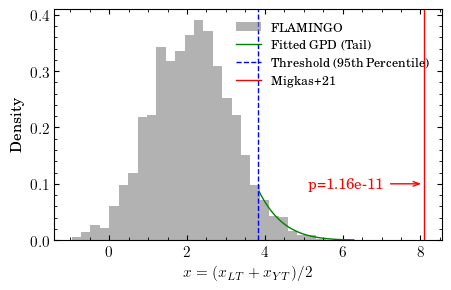

In [9]:
def proj_average_vector(delta_h0_x, n_sigma_x, delta_h0_y, n_sigma_y, theta):
    """ vec{z} = (vec{x} + vec{y})/2
        The projected value is |vec{z}| = 1/2 (xcos(theta/2) + ycos(theta/2))
    """
    theta = theta * np.pi / 180  # convert angle to radian
    return 1/2 * ((delta_h0_x - delta_h0_x/n_sigma_x) * np.cos(theta/2) + 
                  (delta_h0_y - delta_h0_y/n_sigma_y) * np.cos(theta/2))

def proj_average_scalar(delta_h0_x, n_sigma_x, delta_h0_y, n_sigma_y):
    return 1/2 * ((delta_h0_x - delta_h0_x / n_sigma_x) 
                  + (delta_h0_y - delta_h0_y / n_sigma_y))

# delta_h0_proj = proj_average_vector(
#     delta_h0_x=data_joint['Delta_H0_x'].values,
#     n_sigma_x=data_joint['Significance_x'].values,
#     delta_h0_y=data_joint['Delta_H0_y'].values,
#     n_sigma_y=data_joint['Significance_y'].values,
#     theta=data_joint['Theta'].values   # input angle in degree, will convert to radian before computation
# )

# Project FLAMINGO data
delta_h0_proj = proj_average_scalar(
    delta_h0_x=data_joint['Delta_H0_x'].values,
    n_sigma_x=data_joint['Significance_x'].values,
    delta_h0_y=data_joint['Delta_H0_y'].values,
    n_sigma_y=data_joint['Significance_y'].values,
)

# target_value = default_proj(delta_H0=9, n_sigma=5.4)

# Project target value
target_value = proj_average_scalar(8.7, 2.8, 14, 4.1)

# The number of sigma deviation
sigma_deviation, p_value_sigma = calculate_sigma_p_value(delta_h0_proj, target_value)
print(f"Sigma deviation: {sigma_deviation:.3g}σ, p-value: {p_value_sigma:.3g}")

# Select percentile here
percentile = 95
fix_shape = None
p_value_evt, sigma_evt = calculate_evt_p_value(delta_h0_proj, target_value, fix_shape, percentile)
print(f"Probability of target value: {p_value_evt:.3g}, ({sigma_evt:.3g}sigma)")

# Make fit
threshold = np.percentile(delta_h0_proj, percentile)
exceedances = delta_h0_proj[delta_h0_proj > threshold] - threshold
if fix_shape is not None:
    params = genpareto.fit(exceedances, f0=fix_shape)
else:
    params = genpareto.fit(exceedances)
shape, loc, scale = params

# Plotting results
plt.figure(figsize=(5, 3))
plt.hist(delta_h0_proj, bins=30, density=True, alpha=0.6, color='gray', label='FLAMINGO')
x_vals = np.linspace(threshold, delta_h0_proj.max(), 100)
gpd_pdf = genpareto.pdf(x_vals - threshold, shape, loc, scale) * (1 - percentile / 100)
plt.plot(x_vals[1:], gpd_pdf[1:], color='g', label='Fitted GPD (Tail)')
plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold ({percentile}th Percentile)')
plt.axvline(target_value, color='red', linestyle='-', label=f'Migkas+21')

# Annotate the plot
plt.annotate(f'p={p_value_evt:.2e}', 
         xy=(target_value, 0.1), xycoords='data',
         xytext=(target_value - 1, 0.1), textcoords='data',
         arrowprops=dict(arrowstyle='->,head_width=.15', color='red'),
         horizontalalignment='right', verticalalignment='center', color='red')

plt.xlabel(r'$x = ( x_{LT} + x_{YT}) / 2$')
plt.ylabel('Density')
plt.legend(fontsize=9)

plt.savefig('./to_paper/evs_joint_m21.pdf', bbox_inches='tight')
plt.show()

In [15]:
target_value = proj_average_vector(delta_h0_x=8.7, delta_h0_y=14.0, n_sigma_x=2.8, n_sigma_y=4.1, theta=9)
print(target_value)

target_value = default_proj(delta_H0=9.0, n_sigma=5.4)
print(target_value)

8.064175467113193
7.333333333333334


## Generalized extreme value
fit scipy.stats.genextreme for all

Sigma deviation: 6σ, p-value: 1.93e-09
Probability of target value: 5.15e-08, (5.45sigma)


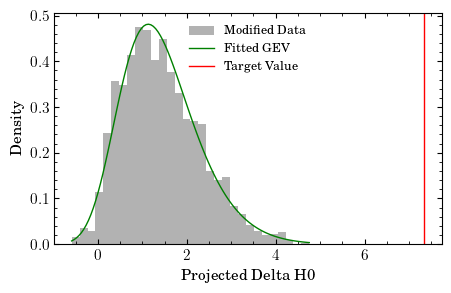

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import genextreme
import matplotlib.pyplot as plt
from scipy.special import erfinv
import math

def load_data(file_path, data_type='mc'):
    data = pd.read_csv(file_path)
    if data_type == 'direct_compare':
        data['Delta_H0'] *= 100
    return data

def extract_data(data, relation):
    df = data[data['Relations'] == relation]
    if 'Delta_H0' in df.columns:
        delta_h0 = df['Delta_H0'].values
    else:
        delta_h0 = df['$\\Delta H_0\\,(\\%)$'].values
    if 'Significance $(\\sigma)$' in df.columns:
        significance = df['Significance $(\\sigma)$'].values
    else:
        significance = df['Significance'].values
    return delta_h0, significance

def calculate_sigma_p_value(delta_h0_proj, target_value):
    median = np.median(delta_h0_proj)
    sigma_84th = np.percentile(delta_h0_proj, 84)
    sigma = sigma_84th - median
    sigma_deviation = np.abs((target_value - median) / sigma)
    p_value_sigma = 1 - math.erf(sigma_deviation / np.sqrt(2))
    return sigma_deviation, p_value_sigma

def calculate_gev_p_value(delta_h0_proj, target_value):
    # Fit GEV to the data
    params = genextreme.fit(delta_h0_proj)
    shape, loc, scale = params

    # Calculate the p-value using the CDF of the fitted GEV distribution
    p_value_gev = 1 - genextreme.cdf(target_value, *params)

    # Transform to sigma (Gaussian equivalent deviation)
    sigma_deviation = np.sqrt(2) * erfinv(1 - p_value_gev)

    return p_value_gev, sigma_deviation

# The first projection function
def default_proj(delta_H0, n_sigma):
    return delta_H0 - delta_H0 / n_sigma

def proj_average_vector(delta_h0_x, n_sigma_x, delta_h0_y, n_sigma_y, theta):
    """ vec{z} = (vec{x} + vec{y})/2
        The projected value is |vec{z}| = 1/2 (xcos(theta/2) + ycos(theta/2))
    """
    theta = theta * np.pi / 180  # convert angle to radian
    return 1/2 * ((delta_h0_x - delta_h0_x/n_sigma_x) * np.cos(theta/2) + 
                  (delta_h0_y - delta_h0_y/n_sigma_y) * np.cos(theta/2))

delta_h0_proj = proj_average_vector(
    delta_h0_x=data_joint['Delta_H0_x'].values,
    n_sigma_x=data_joint['Significance_x'].values,
    delta_h0_y=data_joint['Delta_H0_y'].values,
    n_sigma_y=data_joint['Significance_y'].values,
    theta=data_joint['Theta'].values   # input angle in degree, will convert to radian before computation
)

target_value = default_proj(delta_H0=9.0, n_sigma=5.4)

sigma_deviation, p_value_sigma = calculate_sigma_p_value(delta_h0_proj, target_value)
print(f"Sigma deviation: {sigma_deviation:.3g}σ, p-value: {p_value_sigma:.3g}")

p_value_gev, sigma_gev = calculate_gev_p_value(delta_h0_proj, target_value)
print(f"Probability of target value: {p_value_gev:.3g}, ({sigma_gev:.3g}sigma)")

# Plotting results
params = genextreme.fit(delta_h0_proj)
shape, loc, scale = params

plt.figure(figsize=(5, 3))
plt.hist(delta_h0_proj, bins=30, density=True, alpha=0.6, color='gray', label='Modified Data')
x_vals = np.linspace(delta_h0_proj.min(), target_value, 100)
gev_pdf = genextreme.pdf(x_vals, shape, loc, scale)
plt.plot(x_vals, gev_pdf, color='g', label='Fitted GEV')
plt.axvline(target_value, color='red', linestyle='-', label='Target Value')
plt.xlabel('Projected Delta H0')
plt.ylabel('Density')
plt.legend(fontsize=9)
plt.title('Fitting Generalized Extreme Value Distribution')
plt.show()